Some Data Analysis of the JokeDB (by Yuji Mori)

### Summary of Findings:
* 22 user profiles must be removed (since they did not rate anything; see below)
* User with id=508 sent his/her ratings twice, OR two people share the same ID. Either way, one set must be removed.
* Joke ID = 575 could be rated twice (see analysis for details)

-----

In [3]:
import numpy as np
import pandas as pd

import sqlite3

# Exectute SQL commands and store as an sqlite file (newthing.db):
qry = open('jokedb.sql', 'r').read()
conn = sqlite3.connect('newthing.db')
c = conn.cursor()
c.executescript(qry)
conn.commit()
c.close()
conn.close()

In [4]:
conn = sqlite3.connect('newthing.db')

In [5]:
# Get table names:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print name[0]

JokeRater
sqlite_sequence
Joke
JokeRating


--------

In [55]:
user_df = pd.read_sql_query("SELECT * FROM JokeRater", conn)
# Replace empty strings with NaN so pandas can recognize missing values
user_df.replace('',np.nan,inplace=True)

In [34]:
# General information about this table:
print "Shape: {}".format(user_df.shape)
print "Column Names: {}".format(list(user_df.columns))

Shape: (117, 11)
Column Names: ['id', 'joke_submitter_id', 'gender', 'age', 'birth_country', 'major', 'preferred_joke_genre', 'preferred_joke_genre2', 'preferred_joke_type', 'favorite_music_genre', 'favorite_movie_genre']


-------

###  Missing Values per User Feature

In [56]:
def na_per_feature(column):
    '''Determine how many elements in a pd.Series is NaN (missing).'''
    return column.isnull().sum()

missing_user_features = user_df.apply(na_per_feature,axis=0)

missing_user_features

id                        0
joke_submitter_id         0
gender                    0
age                       0
birth_country             6
major                     0
preferred_joke_genre      0
preferred_joke_genre2     9
preferred_joke_type      11
favorite_music_genre      0
favorite_movie_genre      0
dtype: int64

**Out of 117 users**,
* 6 did not report country of birth
* 9 did not report a 2nd preferred joke genre
* 11 did not report a preferred joke type

----------

### Joke ID's: How many people in our class can't follow instructions?
ID's must be consistent (1:1) between the ratings form and the user profile form. Check if this is true: 

In [29]:
ratings_df = pd.read_sql_query("SELECT * FROM JokeRating", conn)

In [60]:
len(ratings_df['joke_rater_id'].unique())

95

**Though 117 people created user profiles, only 95 people rated jokes.**

It may be best to remove these (22) user profiles from the database:

In [67]:
list(set(user_df['id'].unique()) - set(ratings_df['joke_rater_id'].unique()))

[514,
 521,
 543,
 548,
 550,
 553,
 555,
 557,
 558,
 559,
 454,
 455,
 456,
 479,
 482,
 489,
 490,
 493,
 496,
 498,
 504,
 509]

Conversely, **Every joke rating submission can be traced back to a user profile!** So no ratings need to be deleted (by the Data Team, at least).

--------------

### How many jokes were rated by each person?

In [70]:
# PRE-CHECK
# no NaNs exist in this table, which makes things easier.
ratings_df.apply(na_per_feature,axis=0)

id               0
rating           0
joke_id          0
joke_rater_id    0
dtype: int64

In [121]:
# Count the number of ratings per joke_rater_ID :
from collections import Counter

# A list of 2-tuples, length (n)
ratings_per_user = Counter(ratings_df['joke_rater_id']).items()

# A pair of n-tuples (same info as above, just in two separate structures)
rater, no_jokes = zip(*Counter(ratings_df['joke_rater_id']).items())

In [112]:
# total number of jokes:
# WE EXPECT THIS TO BE THE MAXIMUM!
len(np.unique(ratings_df['joke_id']))

153

### **PROBLEM:** If there are 153 jokes in the database, how did these people rate 1+ more?

In [160]:
# How did these people rate more jokes than available?
# np.where(np.array(no_jokes)>153)[0]
[rater[i] for i in np.where(np.array(no_jokes)>153)[0]]

[513,
 516,
 522,
 525,
 527,
 528,
 539,
 542,
 546,
 552,
 453,
 458,
 462,
 464,
 469,
 473,
 476,
 478,
 480,
 483,
 506,
 508]

**FIRST CASE**: One person rated over 300 jokes. Most likely, they submitted the form twice. Let's check:

In [175]:
user_df[user_df['id']==508]

# all ratings by the user with id=508
ratings_508 = ratings_df[ratings_df['joke_rater_id']==508]
# we want to know if the jokes are unique or not
len(ratings_508)

306

In [135]:
len(np.unique(ratings_508['joke_id']))

153

So yes, he/she submitted the form twice.

**SECOND CASE:** Everyone else in the list had one extra joke rating. To investigate, we must compare the joke ID's in the ratings table to the joke ID's in the joke table: 

In [187]:
# first just visually investigate one of the cases: 
ratings_513 = ratings_df[ratings_df['joke_rater_id']==513]

In [188]:
# Check for duplicate rows within entire dataset:
ratings_513_dropped = ratings_513.drop_duplicates()
ratings_513_dropped.shape
# No pure duplicates found!

(154, 4)

In [189]:
# Now check each column for duplicate values:
def howlong(column):
    '''Check how many unique values exist in each column:'''
    return(len(np.unique(column)))

ratings_513.apply(howlong)

id               154
rating             5
joke_id          153
joke_rater_id      1
dtype: int64

So, we can hypothesize that two ratings point to a single joke. To pinpoint the problem:

In [192]:
mask = ratings_513['joke_id'].duplicated(keep=False)
ratings_513[mask]

,id,rating,joke_id,joke_rater_id
4049,47352,3,575,513
4138,47441,1,575,513


**Is this (duplication of joke_id=575) true for every case?**

In [213]:
def check_double_up(rater_id):
    ratings_subset = ratings_df[ratings_df['joke_rater_id']==rater_id]
    mask_i = ratings_subset['joke_id'].duplicated(keep=False)
    double_up = np.unique(ratings_subset[mask_i]['joke_id'])
    return double_up

In [215]:
double_candidates = [rater[i] for i in np.where(np.array(no_jokes)>153)[0]]
double_candidates_no508 = [x for x in double_candidates if x != 508]
[check_double_up(i) for i in double_candidates_no508]

[array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575]),
 array([575])]

-----------

For now, let's just remove the big outlier (joke rater 508) and make a density plot:

In [204]:
rating_count_plotting = [x for x in list(no_jokes) if x <= 153]

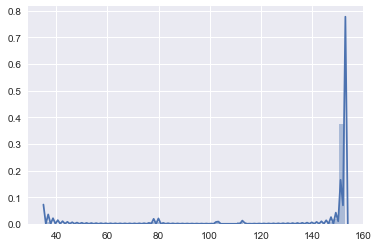

In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(rating_count_plotting,hist=True,kde=True)